In [1]:
import pymongo
from pymongo import MongoClient
import pprint
import math
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
# Connect to the cluster
conn_str = "mongodb+srv://<ID>:<password>@udatabases.a2oqj.mongodb.net/?retryWrites=true&w=majority&appName=UDatabases"
client = MongoClient(conn_str, serverSelectionTimeoutMS=5000)
try:
    print(client.server_info())
except Exception:
    print("Unable to connect to the server.")


{'version': '8.0.4', 'gitVersion': 'bc35ab4305d9920d9d0491c1c9ef9b72383d31f9', 'modules': ['enterprise'], 'allocator': 'tcmalloc-google', 'javascriptEngine': 'mozjs', 'sysInfo': 'deprecated', 'versionArray': [8, 0, 4, 0], 'bits': 64, 'debug': False, 'maxBsonObjectSize': 16777216, 'storageEngines': ['devnull', 'inMemory', 'queryable_wt', 'wiredTiger'], 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1735624168, 25), 'signature': {'hash': b'\xf2\x14\xd8\x94\xf5\xd9\xf7\x92\xe01m~\x12\x9f\xb6C\xdd\xfc\xbb9', 'keyId': 7421199954112151709}}, 'operationTime': Timestamp(1735624168, 25)}


In [5]:
# Get the amazone database
db = client.Amazone

In [ ]:
# Insert/Update an order in current_orders when a customer adds a fresh product to cart

def insert_new_fresh_item(customer_id, item, store_id):
    
    # Step 1: Fetch product details to calculate total cost
    product = db.fresh_products.find_one({"product_id": item["product_id"]})
    if not product:
        raise ValueError("Product not found")

    total_cost = product["selling_price"] * item["quantity"]
    
    # Step 2: Check if an order already exists for the customer and store
    existing_order = db.current_orders.find_one({
        "customer_id": customer_id,
        "category": "fresh",
        "store": store_id,
        "status": "pending"
    })

    if existing_order:

        existing_item = next(
        (existing for existing in existing_order["item"] if existing["product_id"] == item["product_id"]),
        None
        )

        if existing_item:
            # Update the quantity of the existing item
            db.current_orders.update_one(
                {"_id": existing_order["_id"], "item.product_id": item["product_id"]},
                {"$inc": {"item.$.quantity": item["quantity"]}}
            )
            print(f"Updated quantity of Product ID {item['product_id']} in Order ID: {existing_order['order_id']}")
        else:
            # Get max item no
            max_item_no = max([existing["item_no"] for existing in existing_order["item"]], default=0)
            item["item_no"] = max_item_no + 1
            # Add the new item to the order
            db.current_orders.update_one(
                {"_id": existing_order["_id"]},
                {"$push": {"item": item}}
            )
            print(f"Added new Product ID {item['product_id']} to Order ID: {existing_order['order_id']}")
            
        # Update the total cost
        db.current_orders.update_one(
            {"_id": existing_order["_id"], "item.product_id": item["product_id"]},
            {"$inc": {"total_cost": total_cost}}
        )
        return existing_order
        
    else:
        # Step 3: Create a new order
        last_order = list(db.current_orders.find().sort("order_id", -1).limit(1))
        next_order_id = last_order[0]["order_id"] + 1 if last_order else 1
        item["item_no"] = 1

        # Step 4: Prepare new order data
        new_order = {
            "order_id": next_order_id,
            "total_cost": total_cost,
            "order_date": datetime.now(),
            "customer_id": customer_id,
            "category": "fresh",
            "item": [item],
            "status": "pending",
            "store": store_id
        }

        # Step 5: Insert the new order
        result = db.current_orders.insert_one(new_order)
        print(f"New order created with ID: {new_order['order_id']}")
        return new_order

customer_id = 123
item = {"product_id": 46, "quantity": 3}
store_id = 1

try:
    order = insert_new_fresh_item(customer_id, item, store_id)
except ValueError as e:
    print("Error:", e)

Added new Product ID 46 to Order ID: 2001


In [ ]:
# Update order status when payment is confirmed

def order_confirm(customer_id, store_id):
    
    # Step 1: Find the pending order for the customer
    order = db.current_orders.find_one({
        "customer_id": customer_id,
        "category": "fresh",
        "status": "pending",
        "store": store_id
    })
    
    if not order:
        raise ValueError("No pending order found for the customer.")
    
    
    # Step 2: Fetch store details
    store = db.stores.find_one({"store_id": store_id})
    if not store:
        raise ValueError("Store not found")

    store_location = store["location"]

    # Step 3: Find the closest available driver
    drivers = db.amazone_partners.find({
        "on_delivery_errand": False,
        "status": {"$eq": "Active"}
    })

    closest_driver = None
    min_distance = float("inf")

    for driver in drivers:
        driver_location = driver["location"]
        distance = math.sqrt(
            (driver_location["latitude"] - store_location["latitude"])**2 +
            (driver_location["longitude"] - store_location["longitude"])**2
        )
        if distance < min_distance:
            min_distance = distance
            closest_driver = driver

    if not closest_driver:
        raise ValueError("No available drivers")

    # Update driver's status to Active
    db.amazone_partners.update_one(
        {"_id": closest_driver["_id"]},
        {
            "$set": {
                "on_delivery_errand": True
            }
        }
    )
    
    # Step 4: Update the order
    estimated_arrival_time = datetime.now() + timedelta(hours=1)
    db.current_orders.update_one(
        {"_id": order["_id"]},
        {
            "$set": {
                "status": "confirmed",
                "order_date": datetime.now(),
                "driver_id": closest_driver["partner_id"],
                "estimated_arrival_time": estimated_arrival_time
            }
        }
    )
    print(f"Order ID {order['order_id']} confirmed and assigned to driver ID {closest_driver['partner_id']}.")
    return {
        "order_id": order["order_id"],
        "status": "confirmed",
        "driver_id": closest_driver["partner_id"],
        "estimated_arrival_time": estimated_arrival_time
    }

# Example usage
customer_id = 123
store_id = 1

try:
    result = order_confirm(customer_id, store_id)
    print("\nOrder Confirmation Details:")
    print(f"  Order ID: {result["order_id"]}")
    print(f"  Status: Confirmed")
    print(f"  Assigned Driver ID: {result["driver_id"]}")
    print(f"  Estimated Arrival Time: {result["estimated_arrival_time"].strftime('%Y-%m-%d %H:%M:%S')}")

except ValueError as e:
    print("Error:", e)

Order ID 2001 confirmed and assigned to driver ID 5.

Order Confirmation Details:
  Order ID: 2001
  Status: Confirmed
  Assigned Driver ID: 5
  Estimated Arrival Time: 2024-12-31 12:20:26


In [ ]:
# Retrieve and Display Order Details

def get_order_details(order_id):
    # Lookup order details by joining related collections
    order = db.current_orders.aggregate([
        {
            "$match": {"order_id": order_id}
        },
        {
            "$unwind": "$item"
        },
        {
            "$lookup": {
                "from": "fresh_products",
                "localField": "item.product_id",
                "foreignField": "product_id",
                "as": "product_details"
            }
        },
        {
            "$lookup": {
                "from": "products",
                "localField": "item.product_id",
                "foreignField": "product_id",
                "as": "product_names"
            }
        },
        {
            "$unwind": "$product_details"
        },
        {
            "$unwind": "$product_names"
        },
        {
            "$lookup": {
                "from": "amazone_partners",
                "localField": "driver_id",
                "foreignField": "partner_id",
                "as": "driver_details"
            }
        },
        {
            "$unwind": "$driver_details"
        },
        {
            "$group": {
                "_id": "$order_id",
                "total_cost": {"$first": "$total_cost"},
                "estimated_arrival_time": {"$first": "$estimated_arrival_time"},
                "products": {
                    "$push": {
                        "name": "$product_names.name",
                        "category": "$product_details.category",
                        "quantity": "$item.quantity",
                        "selling_price": "$product_details.selling_price"
                    }
                },
                "driver_details": {"$first": "$driver_details"}
            }
        },
        {
            "$project": {
                "_id": 0,
                "order_id": "$_id",
                "total_cost": 1,
                "estimated_arrival_time": 1,
                "products": 1,
                "driver_details": 1
            }
        }
    ])
    return list(order)

order_id = 2001
order_details = get_order_details(order_id)

# Print Order Details
if order_details:
    order = order_details[0]
    print(f"\nOrder Details:\nOrder ID: {order['order_id']}")
    print(f"Total Cost: £{order['total_cost']:.2f}")
    print(f"Estimated Arrival Time: {order['estimated_arrival_time']}")
    
    print("\nProduct Details:")
    for product in order['products']:
        print(f"  Name: {product['name']}")
        print(f"  Category: {product['category']}")
        print(f"  Quantity: {product['quantity']}")
        print(f"  Unit Price: £{product['selling_price']:.2f}")
        print("-" * 30)

    driver = order['driver_details']
    print("\nDriver Details:")
    print(f"  Name: {driver['name']}")
    print(f"  Rating: {driver['rating']}")
    print(f"  Location: Latitude: {driver['location']['latitude']}, Longitude: {driver['location']['longitude']}")
else:
    print("No details found for the provided order ID.")

with open("Question1.json", "w") as file:
    json.dump(order_details, file, default=str, indent=4)



Order Details:
Order ID: 2001
Total Cost: £19.60
Estimated Arrival Time: 2024-12-31 12:20:26.932000

Product Details:
  Name: Organic Strawberries
  Category: Fruits and Vegetables
  Quantity: 2
  Unit Price: £5.00
------------------------------
  Name: Organic Bananas
  Category: Fruits and Vegetables
  Quantity: 3
  Unit Price: £3.20
------------------------------

Driver Details:
  Name: David Clark
  Rating: 4
  Location: Latitude: 53.49046, Longitude: -2.208992


In [ ]:
# Get list of fresh products according to users location

def get_fresh_products(user_location):
    nearby_stores = []
    user_lat, user_lon = user_location

    # Fetch all stores with fresh products
    stores = db["stores"].find()
    for store in stores:
        store_lat = store['location']['latitude']
        store_lon = store['location']['longitude']       
        distance = math.sqrt(
            (user_location[0] - store_lat)**2 +
            (user_location[1] - store_lon)**2
        )

        # Assuming a threshold for distance (e.g., 0.1 degrees ~ 10 km in latitude/longitude terms)
        if distance <= 0.1:
            nearby_stores.append(store['store_id'])

    # Aggregate results
    fresh_products = db.fresh_products.aggregate([
        {
            "$match": {
                "store_id": {"$in": nearby_stores}
            }
        },
        {
            "$lookup": {
                "from": "products",
                "localField": "product_id",
                "foreignField": "product_id",
                "as": "product_details"
            }
        },
        {
            "$unwind": "$product_details"  # Flatten product details
        },
        {
            "$project": {
                "_id": 0,
                "name": "$product_details.name",  # Get name from products collection
                "category": 1,
                "description": 1,
                "price": "$selling_price",
            }
        }
    ])


    # Display the products
    results = []
    for product in fresh_products:
        results.append({
            "name": product["name"],
            "category": product["category"],
            "description": product["description"],
            "price": product["price"],
        })

    return results, nearby_stores

user_location = (53.4808, -2.3426)
available_products, nearby_stores = get_fresh_products(user_location)

if available_products:
    print(f"\nAvailable Fresh Products in stores: {','.join(map(str, nearby_stores))}")
    for product in available_products:
        print(f"  Name: {product['name']}")
        print(f"  Category: {product['category']}")
        print(f"  Description: {product['description']}")
        print(f"  Price: £{product['price']:.2f}")
        print("-" * 30)
else:
    print("No fresh products available in nearby stores.")

with open("Question2.json", "w") as file:
    json.dump(available_products, file, default=str, indent=4)


Available Fresh Products in stores: 1,5,6
  Name: Organic Gala Apples
  Category: Fruits and Vegetables
  Description: Crisp and sweet organic gala apples.
  Price: £4.00
------------------------------
  Name: Organic Bananas
  Category: Fruits and Vegetables
  Description: Ripe and sweet organic bananas.
  Price: £3.20
------------------------------
  Name: Organic Strawberries
  Category: Fruits and Vegetables
  Description: Juicy and sweet organic strawberries.
  Price: £5.00
------------------------------
  Name: Baby Carrots
  Category: Fruits and Vegetables
  Description: Sweet and crunchy baby carrots.
  Price: £2.50
------------------------------
  Name: Cherry Tomatoes
  Category: Fruits and Vegetables
  Description: Juicy and flavorful cherry tomatoes.
  Price: £3.00
------------------------------
  Name: Fresh Green Beans
  Category: Fruits and Vegetables
  Description: Crunchy and fresh green beans.
  Price: £2.25
------------------------------
  Name: Red Apples
  Categor

In [ ]:
# Adding a product to the cart

def insert_new_regular_item(customer_id, item):
    
    # Step 1: Fetch product details to calculate total cost
    product = db.regular_products.find_one({"product_id": item["product_id"]})
    if not product:
        raise ValueError("Product not found")

    total_cost = product["selling_price"] * item["quantity"]
    
    # Step 2: Check if an order already exists for the customer and store
    existing_order = db.current_orders.find_one({
        "customer_id": customer_id,
        "category": "regular",
        "status": "pending"
    })

    if existing_order:

        existing_item = next(
        (existing for existing in existing_order["item"] if existing["product_id"] == item["product_id"]),
        None
        )

        if existing_item:
            # Update the quantity of the existing item
            db.current_orders.update_one(
                {"_id": existing_order["_id"], "item.product_id": item["product_id"]},
                {"$inc": {"item.$.quantity": item["quantity"]}}
            )
            print(f"Updated quantity of Product ID {item['product_id']} in Order ID: {existing_order['order_id']}")
        else:
            # Get max item no
            max_item_no = max([existing["item_no"] for existing in existing_order["item"]], default=0)
            item["item_no"] = max_item_no + 1
            # Add the new item to the order
            db.current_orders.update_one(
                {"_id": existing_order["_id"]},
                {"$push": {"item": item}}
            )
            print(f"Added new Product ID {item['product_id']} to Order ID: {existing_order['order_id']}")
            
        # Update the total cost
        db.current_orders.update_one(
            {"_id": existing_order["_id"], "item.product_id": item["product_id"]},
            {"$inc": {"total_cost": total_cost}}
        )
        return existing_order
        
    else:
        # Step 3: Create a new order
        last_order = list(db.current_orders.find().sort("order_id", -1).limit(1))
        next_order_id = last_order[0]["order_id"] + 1 if last_order else 1
        item["item_no"] = 1

        # Step 4: Prepare new order data
        new_order = {
            "order_id": next_order_id,
            "total_cost": total_cost,
            "order_date": datetime.now(),
            "customer_id": customer_id,
            "category": "regular",
            "item": [item],
            "status": "pending",
        }

        # Step 5: Insert the new order
        result = db.current_orders.insert_one(new_order)
        print(f"New order created with ID: {new_order['order_id']}")
        return new_order

customer_id = 123
item = {"product_id": 41, "quantity": 1}

try:
    order = insert_new_regular_item(customer_id, item)
except ValueError as e:
    print("Error:", e)

New order created with ID: 2025


In [ ]:
# Update order status when payment is confirmed

def order_confirm_regular(customer_id):
    
    # Step 1: Find the pending order for the customer
    order = db.current_orders.find_one({
        "customer_id": customer_id,
        "category": "regular",
        "status": "pending",
    })
    
    if not order:
        raise ValueError("No pending order found for the customer.")
     
    # Step 2: Update the order
    estimated_arrival_time = datetime.now() + timedelta(days=2)
    db.current_orders.update_one(
        {"_id": order["_id"]},
        {
            "$set": {
                "status": "confirmed",
                "order_date": datetime.now(),
                "estimated_arrival_time": estimated_arrival_time
            }
        }
    )
    print(f"Order ID {order['order_id']} confirmed.")
    return {
        "order_id": order["order_id"],
        "status": "confirmed",
        "estimated_arrival_time": estimated_arrival_time
    }

# Example usage
customer_id = 123

try:
    result = order_confirm_regular(customer_id)
    print("\nOrder Confirmation Details:")
    print(f"  Order ID: {result["order_id"]}")
    print(f"  Status: Confirmed")
    print(f"  Estimated Arrival Time: {result["estimated_arrival_time"].strftime('%Y-%m-%d %H:%M:%S')}")

except ValueError as e:
    print("Error:", e)

Order ID 2025 confirmed.

Order Confirmation Details:
  Order ID: 2025
  Status: Confirmed
  Estimated Arrival Time: 2025-01-02 11:21:25


In [ ]:
# Get order details

def get_regular_order_details(order_id):
    # Lookup order details by joining related collections
    order = db.current_orders.aggregate([
        {
            "$match": {"order_id": order_id}
        },
        {
            "$unwind": "$item"
        },
        {
            "$lookup": {
                "from": "regular_products",
                "localField": "item.product_id",
                "foreignField": "product_id",
                "as": "product_details"
            }
        },
        {
            "$unwind": "$product_details"
        },
        {
            "$lookup": {
                "from": "products",
                "localField": "item.product_id",
                "foreignField": "product_id",
                "as": "product_names"
            }
        },
        {
            "$unwind": "$product_names"
        },
        {
            "$group": {
                "_id": "$order_id",
                "total_cost": {"$first": "$total_cost"},
                "order_date": {"$first": "$order_date"},
                "estimated_arrival_time": {"$first": "$estimated_arrival_time"},
                "products": {
                    "$push": {
                        "name": "$product_names.name",
                        "category": "$product_details.category",
                        "quantity": "$item.quantity",
                        "selling_price": "$product_details.selling_price"
                    }
                }
            }
        },
        {
            "$project": {
                "_id": 0,
                "order_id": "$_id",
                "total_cost": 1,
                "order_date": 1,
                "products": 1,
                "estimated_arrival_time": 1
            }
        }
    ])
    return list(order)

order_id = 2025
order_details = get_regular_order_details(order_id)

# Print Order Details
if order_details:
    order = order_details[0]
    print(f"\nOrder Details:\nOrder ID: {order['order_id']}")
    print(f"Total Cost: £{order['total_cost']:.2f}")
    print(f"Order Date: {order['order_date']}")
    print(f"Estimated Arrival Time: {order['estimated_arrival_time']}")
    
    print("\nProduct Details:")
    for product in order['products']:
        print(f"  Name: {product['name']}")
        print(f"  Category: {product['category']}")
        print(f"  Quantity: {product['quantity']}")
        print(f"  Unit Price: £{product['selling_price']:.2f}")
        print("-" * 30)
else:
    print("No details found for the provided order ID.")

with open("Question3.json", "w") as file:
    json.dump(order_details, file, default=str, indent=4)



Order Details:
Order ID: 2025
Total Cost: £900.00
Order Date: 2024-12-31 11:21:25.281000
Estimated Arrival Time: 2025-01-02 11:21:25.281000

Product Details:
  Name: Sony Bravia 55-inch TV
  Category: Home Appliances
  Quantity: 1
  Unit Price: £900.00
------------------------------


[{'_id': 'MOBILE_PHONES', 'total_sales': 35391}, {'_id': 'HOME_APPLIANCES', 'total_sales': 26835}, {'_id': 'BOOK', 'total_sales': 615.2}, {'_id': 'CDS', 'total_sales': 604.6}, {'_id': 'FRESH_PRODUCTS', 'total_sales': 99.0}]
          Category  Total Sales (£)
0    MOBILE_PHONES          35391.0
1  HOME_APPLIANCES          26835.0
2             BOOK            615.2
3              CDS            604.6
4   FRESH_PRODUCTS             99.0


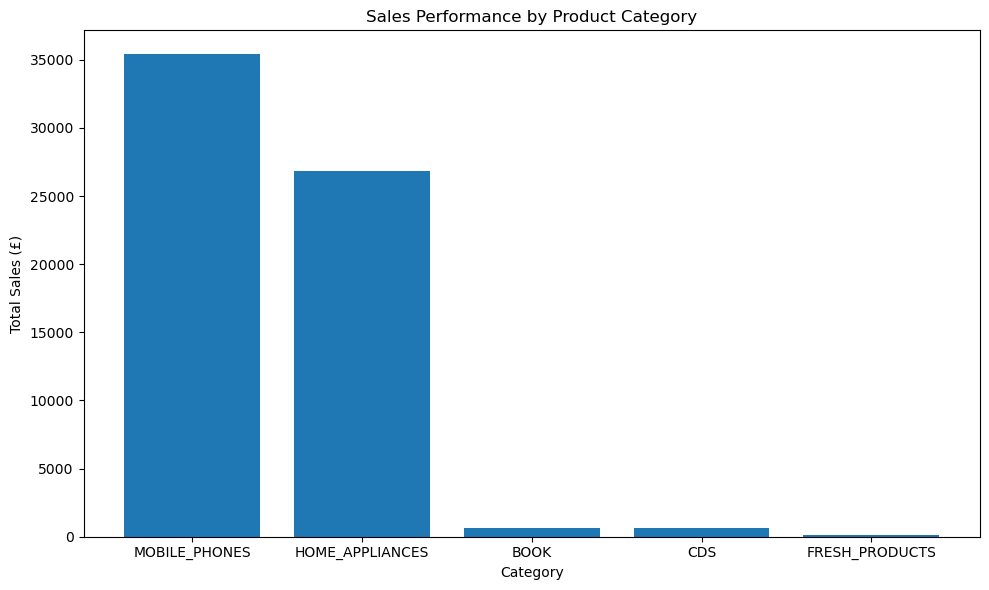

In [ ]:
# Calculate total sales revenue per category

sales_data = db.past_orders.aggregate([
    {
        "$unwind": "$item"
    },
    # Join with the products collection to get the category
    {
        "$lookup": {
            "from": "products",
            "localField": "item.product_id",
            "foreignField": "product_id",
            "as": "product_details"
        }
    },
    {
        "$unwind": "$product_details"
    },
    # Dynamically join with fresh_products or regular_products based on category
    {
        "$lookup": {
            "from": "fresh_products",
            "let": {"product_id": "$item.product_id", "category": "$product_details.category"},
            "pipeline": [
                {"$match": {"$expr": {"$and": [{"$eq": ["$product_id", "$$product_id"]}]}}}
            ],
            "as": "fresh_product_details"
        }
    },
    {
        "$lookup": {
            "from": "regular_products",
            "let": {"product_id": "$item.product_id", "category": "$product_details.category"},
            "pipeline": [
                {"$match": {"$expr": {"$and": [{"$eq": ["$product_id", "$$product_id"]}]}}}
            ],
            "as": "regular_product_details"
        }
    },
    {
        "$addFields": {
            "category": "$product_details.category",
            "selling_price": {
                "$cond": {
                    "if": {"$gt": [{"$size": "$fresh_product_details"}, 0]},
                    "then": {"$arrayElemAt": ["$fresh_product_details.selling_price", 0]},
                    "else": {"$arrayElemAt": ["$regular_product_details.selling_price", 0]}
                }
            }
        }
    },
    # Group by category and calculate total sales
    {
        "$group": {
            "_id": "$category",
            "total_sales": {
                "$sum": {"$multiply": ["$item.quantity", "$selling_price"]}
            }
        }
    },
    {
        "$sort": {"total_sales": -1}  # Sort by highest sales
    }
])

# Convert results to a Pandas DataFrame
sales_list = list(sales_data)
sales_df = pd.DataFrame(sales_list)
sales_df.rename(columns={"_id": "Category", "total_sales": "Total Sales (£)"}, inplace=True)

# Display sales performance as a table
print(sales_df)

# Visualize sales performance using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sales_df["Category"], sales_df["Total Sales (£)"])
plt.title("Sales Performance by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Sales (£)")
plt.tight_layout()
plt.show()

with open("Question4_Query8.json", "w") as file:
    json.dump(sales_list, file, default=str, indent=4)

                      Warehouse  Total Quantity
0    Manchester South Warehouse            2289
1  Manchester Central Warehouse            1693
2    Manchester North Warehouse            1402


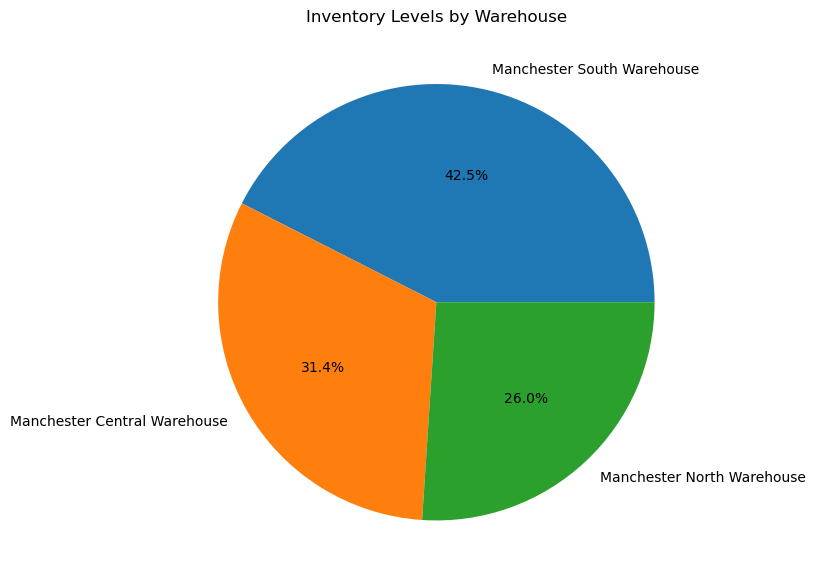

In [ ]:
# Calculate total inventory levels by warehouse
inventory_data = db.daily_inventory_level.aggregate([
    {
        "$group": {
            "_id": "$storage_warehouse_name",
            "total_quantity": {"$sum": "$quantity"}
        }
    },
    {
        "$sort": {"total_quantity": -1}  # Sort by highest inventory
    }
])

# Convert results to a Pandas DataFrame
inventory_list = list(inventory_data)
inventory_df = pd.DataFrame(inventory_list)
inventory_df.rename(columns={"_id": "Warehouse", "total_quantity": "Total Quantity"}, inplace=True)

# Display inventory levels as a table
print(inventory_df)

# Visualize inventory levels using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    inventory_df["Total Quantity"],
    labels=inventory_df["Warehouse"],
    autopct='%1.1f%%',
)
plt.title("Inventory Levels by Warehouse")
plt.tight_layout()
plt.show()

with open("Question4_Query9.json", "w") as file:
    json.dump(inventory_list, file, default=str, indent=4)


In [ ]:
# Move delivered order from current_orders to past_orders
def process_delivered_order(order_id):
    # Fetch the order from current_orders
    order = db.current_orders.find_one({"order_id": order_id})
    if not order:
        print("Order not found.")
        return

    # Remove unnecessary fields
    order.pop("estimated_arrival_time", None)  
    order.pop("status", None)                

    # Add the delivery_time field
    order["delivery_time"] = datetime.now()

    # Insert the cleaned order into past_orders
    db.past_orders.insert_one(order)

    # Remove the order from current_orders
    db.current_orders.delete_one({"order_id": order_id})

    # Update the delivery partner's status if it is a fresh order
    if order["category"] == "fresh":
        db.amazone_partners.update_one(
            {"partner_id": order["driver_id"]},
            {"$set": {"on_delivery_errand": False}}
        )

    print(f"Order {order_id} successfully processed with delivery time added.")
    
order_id = 2001
try:
    process_delivered_order(order_id)
except ValueError as e:
    print("Error:", e)

Order 2001 successfully processed with delivery time added.


In [ ]:
# Fetch the recommended products for a given customer, sorted by predicted rating.
def get_customer_recommendations(customer_id):
    recommendations = db.customers.aggregate([
        {
            "$match": {"customer_id": customer_id}
        },
        {
            "$unwind": "$recommendations"
        },
        {
            "$lookup": {
                "from": "products",
                "localField": "recommendations.product_id",
                "foreignField": "product_id",
                "as": "product_details"
            }
        },
        {
            "$unwind": "$product_details"
        },
        {
            "$project": {
                "_id": 0,
                "product_id": "$recommendations.product_id",
                "predicted_rating": "$recommendations.predicted_rating",
                "product_name": "$product_details.name",
                "category": "$product_details.category"
            }
        },
        {
            "$sort": {"predicted_rating": -1}
        }
    ])
    return list(recommendations)
    
customer_id = 123
recommendations_list = get_customer_recommendations(customer_id)
if recommendations_list:
    print(f"\nTop Recommendations for Customer ID {customer_id}:")
    for idx, recommendation in enumerate(recommendations_list, start=1):
        print(f"{idx}. Product: {recommendation['product_name']}")
        print(f"   Category: {recommendation['category']}")
        print(f"   Predicted Rating: {recommendation['predicted_rating']:.1f}")
        print("-" * 30)
else:
    print(f"No recommendations found for Customer ID {customer_id}.")

with open("Question5_Query11.json", "w") as file:
    json.dump(recommendations_list, file, default=str, indent=4)


Top Recommendations for Customer ID 123:
1. Product: Organic Strawberries
   Category: FRESH_PRODUCTS
   Predicted Rating: 4.2
------------------------------
2. Product: Born to Run
   Category: CDS
   Predicted Rating: 3.8
------------------------------


In [ ]:
# Calculate the average rating and total number of ratings for each product.
def get_product_ratings():
    ratings = db.ratings.aggregate([
        {
            "$group": {
                "_id": "$product_id",
                "average_rating": {"$avg": "$rating"},
                "total_ratings": {"$sum": 1}
            }
        },
        {
            "$lookup": {
                "from": "products",
                "localField": "_id",
                "foreignField": "product_id",
                "as": "product_details"
            }
        },
        {
            "$unwind": "$product_details"
        },
        {
            "$project": {
                "_id": 0,
                "product_id": "$_id",
                "product_name": "$product_details.name",
                "category": "$product_details.category",
                "average_rating": {"$round": ["$average_rating", 1]},
                "total_ratings": 1
            }
        },
        {
            "$sort": {"average_rating": -1}
        }
    ])
    return list(ratings)
ratings_list = get_product_ratings()
if ratings_list:
    print("\nRatings of Products:")
    for idx, product in enumerate(ratings_list, start=1):
        print(f"{idx}. Product: {product['product_name']}")
        print(f"   Category: {product['category']}")
        print(f"   Average Rating: {product['average_rating']:.1f}")
        print(f"   Total Ratings: {product['total_ratings']}")
        print("-" * 30)
else:
    print("No ratings found for any product.")

with open("Question5_Query12.json", "w") as file:
    json.dump(ratings_list, file, default=str, indent=4)


Ratings of Products:
1. Product: A Night at the Opera
   Category: CDS
   Average Rating: 4.5
   Total Ratings: 2
------------------------------
2. Product: Crime and Punishment
   Category: BOOK
   Average Rating: 4.5
   Total Ratings: 2
------------------------------
3. Product: Instant Pot Duo 7-in-1 Cooker
   Category: HOME_APPLIANCES
   Average Rating: 4.3
   Total Ratings: 3
------------------------------
4. Product: Organic Gala Apples
   Category: FRESH_PRODUCTS
   Average Rating: 4.3
   Total Ratings: 3
------------------------------
5. Product: LG Front Load Washing Machine
   Category: HOME_APPLIANCES
   Average Rating: 4.2
   Total Ratings: 4
------------------------------
6. Product: Redmi Note 10 Pro
   Category: MOBILE_PHONES
   Average Rating: 4.0
   Total Ratings: 4
------------------------------
7. Product: Jane Eyre
   Category: BOOK
   Average Rating: 3.8
   Total Ratings: 4
------------------------------
8. Product: The Wall
   Category: CDS
   Average Rating: 3.8

In [ ]:
# Identify top 10 customers by total spending.
def get_top_customers():
    top_customers = db.past_orders.aggregate([
        {
            "$group": {
                "_id": "$customer_id",
                "total_spent": {"$sum": "$total_order_cost"}
            }
        },
        {
            "$sort": {"total_spent": -1}
        },
        {
            "$limit": 10
        },
        {
            "$lookup": {
                "from": "customers",
                "localField": "_id",
                "foreignField": "customer_id",
                "as": "customer_details"
            }
        },
        {
            "$unwind": "$customer_details"
        },
        {
            "$project": {
                "_id": 0,
                "customer_id": "$_id",
                "name": "$customer_details.name",
                "total_spent": {"$round": ["$total_spent", 2]}
            }
        }
    ])
    return list(top_customers)
    
customers_list = get_top_customers()
if customers_list:
    print("\nTop 10 Customers by Spending:")
    for idx, customer in enumerate(customers_list, start=1):
        print(f"{idx}. Name: {customer['name']}")
        print(f"   Customer ID: {customer['customer_id']}")
        print(f"   Total Spent: £{customer['total_spent']:.2f}")
        print("-" * 30)
else:
    print("No customers found.")

with open("Question5_Query13.json", "w") as file:
    json.dump(customers_list, file, default=str, indent=4)


Top 10 Customers by Spending:
1. Name: Elizabeth Thompson
   Customer ID: 901
   Total Spent: £10392.00
------------------------------
2. Name: Nancy Lewis
   Customer ID: 289
   Total Spent: £7495.00
------------------------------
3. Name: Jamie Howard
   Customer ID: 778
   Total Spent: £6800.60
------------------------------
4. Name: Charlotte Sanchez
   Customer ID: 245
   Total Spent: £4288.00
------------------------------
5. Name: Andrew
   Customer ID: 367
   Total Spent: £3684.00
------------------------------
6. Name: Jennifer Martin
   Customer ID: 634
   Total Spent: £3585.00
------------------------------
7. Name: Sarah Clark
   Customer ID: 891
   Total Spent: £3468.00
------------------------------
8. Name: Jason Roberts
   Customer ID: 167
   Total Spent: £3468.00
------------------------------
9. Name: Karen Rodriguez
   Customer ID: 923
   Total Spent: £3394.80
------------------------------
10. Name: Joshua Gonzalez
   Customer ID: 878
   Total Spent: £3379.00
-----